# SÉPARATION DE SOURCES AUDIO PAR ICA

In [ ]:
# ica_audio.py
# Author: Slim Essid
import pylab as pl
import numpy as np
import wave
from sklearn import decomposition

# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    wf = wave.open(filename)
    s = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16) 
    wf.close()
    return s

def wavwrite(filename, s, nchannels=1): 
    wf = wave.open(filename,'wb') 
    wf.setnchannels(nchannels) 
    wf.setsampwidth(2) 
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily 
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()

s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

# -- Create stereo mix ---------------------------------------------------------
nsmp = min(len(s1), len(s2)) 
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]

# Mixing matrix
A = np.array([ [0.6, 0.5],
            [0.4, 0.5]])

# Do the mix
X = S.dot(A)

# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('./snd/mix.wav', x, nchannels=2)


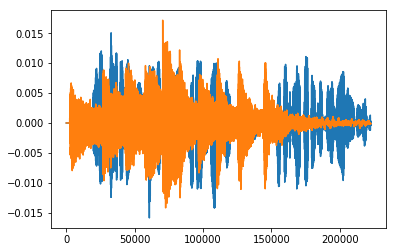

In [48]:
# -- ICA source separation -----------------------------------------------------
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
transformer = FastICA(n_components=2,random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

# Visualise sources
plt.plot(range(len(X_transformed[:,0])),X_transformed[:,0])
plt.plot(range(len(X_transformed[:,1])),X_transformed[:,1])

# Write audio sources
wavwrite('./snd/es02_bis.wav', X_transformed[:,0], nchannels=2)
wavwrite('./snd/si01_bis.wav', X_transformed[:,1], nchannels=2)



# EXTRACTION DE CARACTÉRISTIQUES DE VISAGES

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA...
data before transform (400, 4096)
data after transform, each face is composed by 10 components (400, 10)
done in 0.049s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2222 negative-valued pixels
2129 negative-valued pixels
score Eigenfaces - PCA 0.9125
Extracting the top 10 Non-negative components - NMF...
data before transform (400, 4096)
data after transform, each face is composed by 10 components (400, 10)
done in 5.869s
score Non-negative components - NMF 0.935


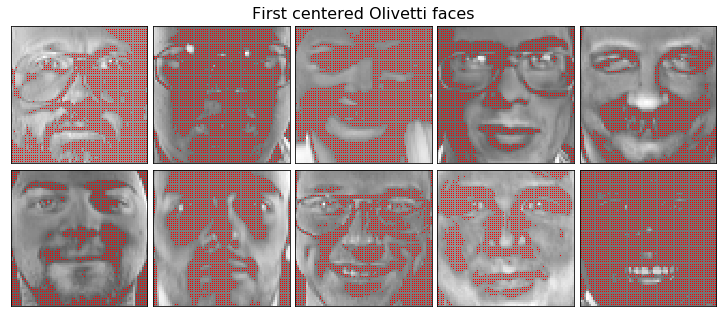

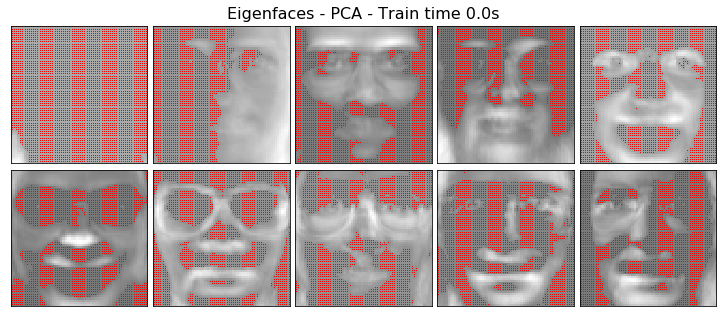

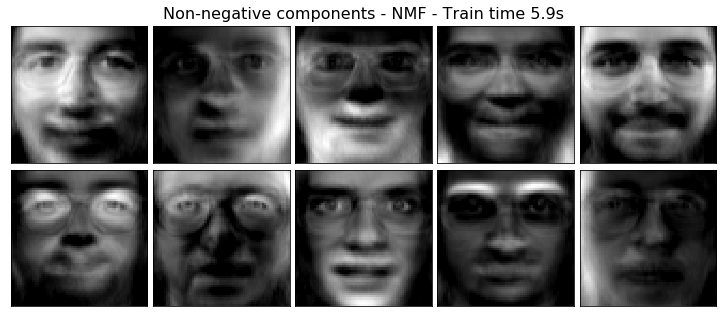

In [87]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState

# Do the mix
X = S.dot(A)
                                         
import pylab as pl 
import numpy as np
from sklearn.datasets import fetch_olivetti_faces 
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# -- Prepare data and define utility functions ---------------------------------
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng) 
faces = dataset.data
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images): 
    pl.figure(figsize=(2. * n_col, 2.26 * n_row)) 
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape) 
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0: 
            yz, xz = dmy 
        comp[comp<0] = 0
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        #print "vmax: %f, vmin: %f" % (vmax, vmin)
        #print comp
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')#, hold=True)
            print(len(dmy[0]), "negative-valued pixels")
        pl.xticks(())
        pl.yticks(())
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods -----------------------------------------------------

# List of the different estimators and whether to center the data

estimators = [('pca', 'Eigenfaces - PCA', decomposition.PCA(n_components=n_components, whiten=True), True),
    ('nmf', 'Non-negative components - NMF', decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
                       max_iter=2000), False) ]

# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = X 
    if center:
        data = X_
    print("data before transform", data.shape)
    data = estimator.fit_transform(data)
    print("data after transform, each face is composed by 10 components", data.shape)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])
#evaluation
    lda= LinearDiscriminantAnalysis().fit(data, labels)
    score = lda.score(data, labels)
    print("score", name, score)

In [67]:
estimators

[('pca',
  'Eigenfaces - PCA',
  PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
      svd_solver='auto', tol=0.0, whiten=True),
  True),
 ('nmf',
  'Non-negative components - NMF',
  NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=2000,
      n_components=10, random_state=None, shuffle=False, solver='cd', tol=1e-06,
      verbose=0),
  False)]

# EXTRACTION DE CARACTÉRISTIQUES DE VISAGES# 

In [66]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: Simplified BSD
from time import time
from sklearn.feature_extraction import text 
from sklearn import decomposition
from sklearn import datasets
                                                             
n_samples = 1000
n_features = 1000
n_topics = 10
n_top_words = 20
# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(shuffle=True, random_state=1)

vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features) 
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." % ( n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf) 
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_): 
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

Loading dataset and extracting TF-IDF features...
done in 18.576s.
Fitting the NMF model on with n_samples=1000 and n_features=1000...
done in 18.925s.
Topic #0:
the of in and on was to as at by which were one is they with for that when two
Topic #1:
to windows is the it this can chip help be file me use key on and thanks clipper problem or
Topic #2:
that is of to not and are the be we as people in it they this or there god their
Topic #3:
edu university cs host posting of nntp in article re cc writes washington reply distribution anyone cwru institute uiuc mit
Topic #4:
com hp in article writes inc stratus netcom corp re sun nntp posting host ca jim org uunet never that
Topic #5:
he his was to and him that who my the in had it but this year ca me team up
Topic #6:
uk ac co of university ___ posting host nntp thanks __ dc sorry college please where mail it test return
Topic #7:
you it to your my have can if and do that car what like get don with so on just
Topic #8:
nasa gov space jpl 

In [78]:
fetch_olivetti_faces


AttributeError: 'function' object has no attribute 'describ'